# Market Simulator
ML for trading Udacity Course exercise

More info:
https://quantsoftware.gatech.edu/Marketsim

A transcription of the Udacity Course lectures can be find on https://docs.google.com/document/d/1ELqlnuTSdc9-MDHOkV0uvSY4RmI1eslyQlU9DgOY_jc/edit?usp=sharing

Kairoart 2018



## Overview

In this project you will create a market simulator that accepts trading orders and keeps track of a portfolio's value over time and then assesses the performance of that portfolio. 

## Part 1: Create a market simulation function

Your job is to implement your market simulator as a function, compute_portvals() that returns a dataframe with one column. It should adhere to the following API: 

    def compute_portvals(orders_file = "./orders/orders.csv", start_val = 1000000, commission = 9.95, impact = 0.005):
        # TODO: Your code here
        return portvals

The start date and end date of the simulation are the first and last dates with orders in the orders_file. The arguments are as follows:

    orders_file is the name of a file from which to read orders, and
    start_val is the starting value of the portfolio (initial cash available)
    commission is the fixed amount in dollars charged for each transaction (both entry and exit)
    impact is the amount the price moves against the trader compared to the historical data at each transaction


The files containing orders are CSV files with the following columns:

    Date (yyyy-mm-dd)
    Symbol (e.g. AAPL, GOOG)
    Order (BUY or SELL)
    Shares (no. of shares to trade)

For example: 

    Date,Symbol,Order,Shares
    2008-12-3,AAPL,BUY,130
    2008-12-8,AAPL,SELL,130
    2008-12-5,IBM,BUY,50


### Goal

**Process Orders** 
Your simulator should calculate the total value of the portfolio for each day using adjusted closing prices. The value for each day is cash plus the current value of equities. The resulting data frame should contain values like this: 

    2008, 12, 3, 1000000
    2008, 12, 4, 1000010
    2008, 12, 5, 1000250
    ...

**Portfolio stats**
You should write your own additional helper function to call compute_portvals() with your own test cases. We suggest that you report the following factors:

    * Plot the price history over the trading period.
    * Sharpe ratio (Always assume you have 252 trading days in an year. And risk free rate = 0) of the total portfolio
    * Cumulative return of the total portfolio
    * Standard deviation of daily returns of the total portfolio
    * Average daily return of the total portfolio
    * Ending value of the portfolio

### How it should work

Your code should keep account of how many shares of each stock are in the portfolio on each day and how much cash is available on each day. Note that negative shares and negative cash are possible. Negative shares mean that the portfolio is in a short position for that stock. Negative cash means that you've borrowed money from the broker.

When a BUY order occurs, you should add the appropriate number of shares to the count for that stock and subtract the appropriate cost of the shares from the cash account. The cost should be determined using the adjusted close price for that stock on that day.

When a SELL order occurs, it works in reverse: You should subtract the number of shares from the count and add to the cash account. 

### Import libraries

In [13]:
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import operator
import sys
import csv
import math

# To fetch data
from pandas_datareader import data as pdr   
import fix_yahoo_finance as yf  
yf.pdr_override()   

# Add plotly for interactive charts
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

### Read orders from file

In [45]:
def readOrdersFileIntoDF(filename):

    ordersDataFrame = pd.read_csv(filename,  parse_dates=['Date'], index_col="Date", na_values=['nan'])
    
    
    # Getting the Symbols from the Orders. This list will be required for fetching the prices
    symbolList = list(set(ordersDataFrame['Symbol']))
    
    # Returning it.
    return ordersDataFrame, symbolList

### Get data from Yahoo for the given dates 

In [46]:
def fetchData(dt_start, dt_end, ls_symbols):

    # Add a day to dt_end for Yahoo purpose
    dt_end = pd.to_datetime(dt_end) + pd.DateOffset(days=1)
    
    # Get data of trading days between the start and the end.
    df = pdr.get_data_yahoo(
            # tickers list (single tickers accepts a string as well)
            tickers = ls_symbols,

            # start date (YYYY-MM-DD / datetime.datetime object)
            # (optional, defaults is 1950-01-01)
            start = dt_start,

            # end date (YYYY-MM-DD / datetime.datetime object)
            # (optional, defaults is Today)
            end = dt_end,

            # return a multi-index dataframe
            # (optional, default is Panel, which is deprecated)
            as_panel = False,

            # group by ticker (to access via data['SPY'])
            # (optional, default is 'column')
            group_by = 'ticker',

            # adjust all OHLC automatically
            # (optional, default is False)
            auto_adjust = False
    )
    #print(df)    
    # Getting the numpy ndarray of Adj Close prices.
    adj_close_price = df.loc[:, (slice(None), ('Adj Close'))]

    
    # returning the Adj Closed prices for all the days    
    return adj_close_price

### Market simulator

In [47]:
def marketsim(initialCash, ordersdf, symbols):

    # reading the boundary dates
    dt_start = ordersdf.index[0]
    dt_end = ordersdf.index[len(ordersdf)-1]

    # All the adjustedClosingPrices fetched from NYSE within the range and for given symbols
    closingPrices = fetchData(dt_start, dt_end, symbols)
    num_tradingDays = len(closingPrices)
    #print(closingPrices)
    
    #Cash for the days
    temp = np.zeros((num_tradingDays, 1))
    cash = pd.DataFrame(temp, columns = ['cashinhand'])
    
    #Value for the days
    temp = np.zeros((num_tradingDays, 1))
    valueFrame = pd.DataFrame(temp, columns = ['valueOfPortfolio'])

    #Setting the first value to be the initial cash amount.
    cash.cashinhand.loc[0] = initialCash
    
    index = 0
 
    for tradingDayIndex in range(num_tradingDays):  
        if tradingDayIndex != 0:
            cash.cashinhand.iloc[tradingDayIndex] = cash.cashinhand.iloc[tradingDayIndex - 1] 
        else:
            cash.cashinhand.iloc[tradingDayIndex] = initialCash
          
        for tradingOrder in ordersdf.index:
            if tradingOrder == closingPrices.index[tradingDayIndex]:
                if ordersdf.Order.iloc[index] == 'BUY':
                    toBuySymbol = ordersdf.Symbol.iloc[index]
                    toBuy = symbols.index(toBuySymbol)
                    numShares = ordersdf.Shares.iloc[index]
                    priceForTheDay = closingPrices.iloc[tradingDayIndex][toBuy]
                    cash.cashinhand.iloc[tradingDayIndex] = cash.cashinhand.iloc[tradingDayIndex] - (priceForTheDay * float(numShares))
                    print("Date: ", tradingOrder,
                          "Symbol: ", toBuySymbol,
                          "Order: ", ordersdf.Order.iloc[index],
                          "Shares: ", numShares,
                          "Price: ", priceForTheDay,
                          "Cash: ", cash.cashinhand.iloc[tradingDayIndex] )
                elif ordersdf.Order.iloc[index] == 'SELL':
                    toSellSymbol = ordersdf.Symbol.iloc[index]
                    toSell = symbols.index(toSellSymbol)
                    numShares = ordersdf.Shares.iloc[index]
                    priceForTheDay = closingPrices.iloc[tradingDayIndex][toSell]
                    cash.cashinhand.iloc[tradingDayIndex] = cash.cashinhand.iloc[tradingDayIndex] + (priceForTheDay * float(numShares))
                    print("Date: ", tradingOrder,
                          "Symbol: ", toSellSymbol,
                          "Order: ", ordersdf.Order.iloc[index],
                          "Shares: ", numShares,
                          "Price: ", priceForTheDay,
                          "Cash: ", cash.cashinhand.iloc[tradingDayIndex] )
                else:
                    print("error")
                index+=1
        

        valueFrame['valueOfPortfolio'] = cash['cashinhand'].values
        
    valueFrame.index = closingPrices.index

    return valueFrame

### Define market simulation function

In [48]:
def compute_portvals(orders_file = "./orders/orders-01.csv", start_val = 1000000, commission = 9.95, impact = 0.005):
    # TODO: Your code here
    # Reading the data from the file, and getting a NumPy matrix
    ordersDataFrame, symbols = readOrdersFileIntoDF(orders_file)

    # Getting data from marketsim
    print("List of transactions")
    valueFrame = marketsim(start_val, ordersDataFrame, symbols)
    return valueFrame, symbols


### Process Orders

In [49]:
# Define input parameters    
of = "./orders/orders-02.csv"   
sv = 1000000  
    
# Process orders 
portvals, symbols = compute_portvals(orders_file = of, start_val = sv)
print(symbols)

List of transactions
[*********************100%***********************]  4 of 4 downloaded
Date:  2011-01-10 00:00:00 Symbol:  AAPL Order:  BUY Shares:  1500 Price:  43.356891999999995 Cash:  934964.662
Date:  2011-01-10 00:00:00 Symbol:  AAPL Order:  SELL Shares:  1500 Price:  43.356891999999995 Cash:  1000000.0
Date:  2011-01-13 00:00:00 Symbol:  AAPL Order:  SELL Shares:  1500 Price:  43.765831 Cash:  1065648.7465
Date:  2011-01-13 00:00:00 Symbol:  IBM Order:  BUY Shares:  4000 Price:  117.880554 Cash:  594126.5304999999
Date:  2011-01-26 00:00:00 Symbol:  GOOG Order:  BUY Shares:  1000 Price:  306.258087 Cash:  287868.4434999999
Date:  2011-02-02 00:00:00 Symbol:  XOM Order:  SELL Shares:  4000 Price:  65.633003 Cash:  550400.4554999999
Date:  2011-02-10 00:00:00 Symbol:  XOM Order:  BUY Shares:  4000 Price:  65.81276700000001 Cash:  287149.3874999999
Date:  2011-03-03 00:00:00 Symbol:  GOOG Order:  SELL Shares:  1000 Price:  302.810516 Cash:  589959.9034999999
Date:  2011-05-03 0

### Portfolio stats

#### Plot the price history over the trading period.

In [30]:
# reading the boundary dates
dt_start = portvals.index[0]
dt_end = portvals.index[len(portvals)-1]

# Getting data from Yahoo
values = fetchData(dt_start, dt_end, symbols)

# Getting the symbol names
columnNames = list(values.head(1)) 
symbols_dict = dict(columnNames)
columnNames = list(symbols_dict.keys()) 

[*********************100%***********************]  4 of 4 downloaded


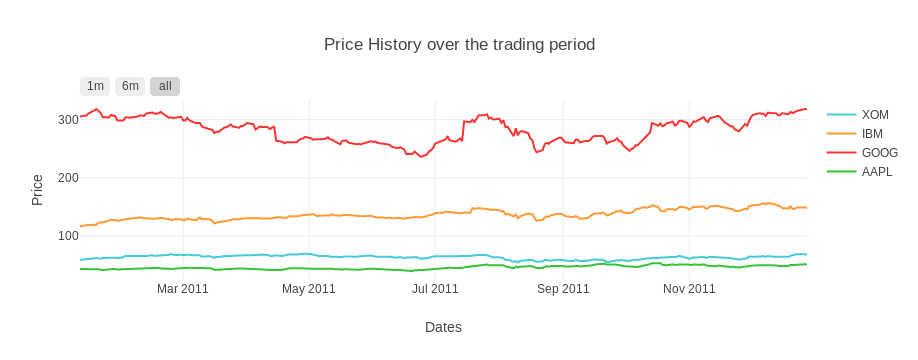

In [31]:
trace_price1 = go.Scatter(
                x=portvals.index,
                y=values.iloc[:,0],
                name = columnNames[0],
                line = dict(color = '#17BECF'),
                opacity = 0.8)
trace_price2 = go.Scatter(
                x=portvals.index,
                y=values.iloc[:,1],
                name = columnNames[1],
                line = dict(color = '#FF8000'),
                opacity = 0.8)
trace_price3 = go.Scatter(
                x=portvals.index,
                y=values.iloc[:,2],
                name = columnNames[2],
                line = dict(color = '#FF0000'),
                opacity = 0.8)
trace_price4 = go.Scatter(
                x=portvals.index,
                y=values.iloc[:,3],
                name = columnNames[3],
                line = dict(color = '#04B404'),
                opacity = 0.8)
data = [trace_price1, trace_price2, trace_price3, trace_price4]

layout = dict(
    title = "Price History over the trading period",
    xaxis = dict(
            title='Dates',
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                         label='1m',
                         step='month',
                         stepmode='backward'),
                    dict(count=6,
                         label='6m',
                         step='month',
                         stepmode='backward'),
                    dict(step='all')
                ])
            ),
            ),

    yaxis = dict(
            title='Price')

    )



fig = dict(data=data, layout=layout)
iplot(fig)

### Fecth SPX data for comparison

In [34]:
# reading the boundary dates
dt_start = portvals.index[0]
dt_end = portvals.index[len(df)-1]

symbolSPX = ['SPX']
spxValues = pdr.get_data_yahoo(
            # tickers list (single tickers accepts a string as well)
            tickers = symbolSPX,

            # start date (YYYY-MM-DD / datetime.datetime object)
            # (optional, defaults is 1950-01-01)
            start = dt_start,

            # end date (YYYY-MM-DD / datetime.datetime object)
            # (optional, defaults is Today)
            end = dt_end,

            # return a multi-index dataframe
            # (optional, default is Panel, which is deprecated)
            as_panel = False,

            # group by ticker (to access via data['SPY'])
            # (optional, default is 'column')
            group_by = 'ticker',

            # adjust all OHLC automatically
            # (optional, default is False)
            auto_adjust = False
    )


# Convert string to number
spxValues['Adj Close'] = pd.to_numeric(spxValues['Adj Close'], errors='coerce')
portf_SPX_value = pd.Series(spxValues['Adj Close'])
#print(portf_SPX_value)


[*********************100%***********************]  1 of 1 downloaded


### Standard deviation of daily returns of the total portfolio 

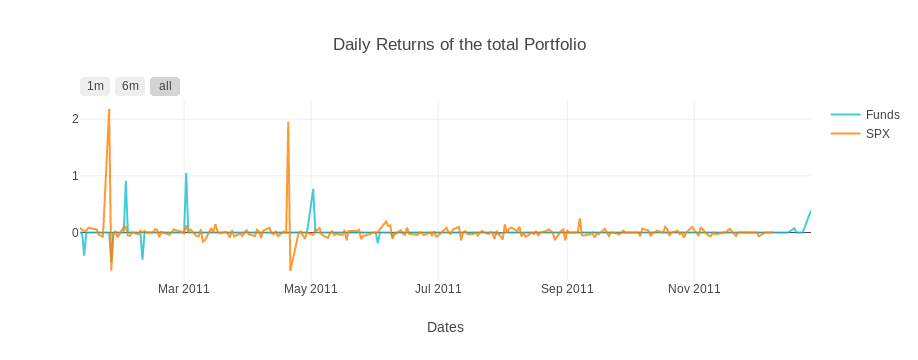

In [37]:
# Get daily portfolio value
df = portvals

portf_value = pd.Series(df['valueOfPortfolio'])


# Daily returns funds
daily_rets = portf_value.pct_change(1)
daily_rets = daily_rets[1:]  

# daily returns normedSPX
daily_rets_SPX = portf_SPX_value.pct_change()
daily_rets_SPX = daily_rets_SPX[1:]

trace_daily_rets = go.Scatter(
                x=df.index,
                y=daily_rets,
                name = "Funds",
                line = dict(color = '#17BECF'),
                opacity = 0.8)

trace_daily_rets_SPX = go.Scatter(
                x=df.index,
                y=daily_rets_SPX,
                name = "SPX",
                line = dict(color = '#FF8000'),
                opacity = 0.8)

data = [trace_daily_rets, trace_daily_rets_SPX]

layout = dict(
    title = "Daily Returns of the total Portfolio",
    xaxis = dict(
            title='Dates',
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                         label='1m',
                         step='month',
                         stepmode='backward'),
                    dict(count=6,
                         label='6m',
                         step='month',
                         stepmode='backward'),
                    dict(step='all')
                ])
            ),
            ),

    yaxis = dict(
            title='')

    )



fig = dict(data=data, layout=layout)
iplot(fig)

# Standar deviation daily return
stddevPort = daily_rets.std()

# Standar deviation SPX daily return
stddevSPX = daily_rets_SPX.std()



### Average daily return of the total portfolio 

In [38]:
# Averrage daily returns
averagePortfolioDailyRets = daily_rets.mean()

# Averrage SPX daily returns
averageSPXDailyRets = daily_rets_SPX.mean()

### Sharpe ratio 

(Always assume you have 252 trading days in an year. And risk free rate = 0) of the total portfolio 

In [39]:
# Sharpe ratio funds
sharpeRatioPort = averagePortfolioDailyRets / stddevPort
k = math.sqrt(252)
sharpeRatioPort = k * sharpeRatioPort

# Sharpe ratio SPX
sharpeRatioSPX = averageSPXDailyRets / stddevSPX
k = math.sqrt(252)
sharpeRatioSPX = k * sharpeRatioSPX

### Cumulative return of the total portfolio

In [40]:
# Cumulative return funds
totalPortRet = (portf_value[-1] / portf_value[0] -1)

# Cumulative return SPX
totalSPXRet = (portf_SPX_value[-1] / portf_SPX_value[0] -1)

1164966.73229
999999.0


### Ending value of the portfolio

In [42]:
# Ending value
end_value = portvals.valueOfPortfolio.iloc[-1]


1164966.73229


## Results

In [44]:
print("The final value of the portfolio using the sample file is ", portvals.index[-1], " ", portvals['valueOfPortfolio'].iloc[-1])
print("Details of the Performance of the portfolio")
print("")

print("Data Range :", dt_start ," to ", dt_end)

print("")

print("Sharpe Ratio of Fund :", sharpeRatioPort)
print("Sharpe Ratio of $SPX :", sharpeRatioSPX)
print("")

print("Total Return of Fund :", totalPortRet)
print("Total Return of $SPX :", totalSPXRet)

print("")

print("Standard Deviation of Fund :", stddevPort)
print("Standard Deviation of $SPX :", stddevSPX)

print("")

print("Average Daily Return of Fund :", averagePortfolioDailyRets)
print("Average Daily Return of $SPX :", averageSPXDailyRets)

The final value of the portfolio using the sample file is  2011-12-28 00:00:00   1164966.73229
Details of the Performance of the portfolio

Data Range : 2011-01-10 00:00:00  to  2011-12-28 00:00:00

Sharpe Ratio of Fund : 0.8447133457390065
Sharpe Ratio of $SPX : 0.7992904543546481

Total Return of Fund : 0.16496673228999992
Total Return of $SPX : -0.5172459893048128

Standard Deviation of Fund : 0.11796374128776896
Standard Deviation of $SPX : 0.21040820069241237

Average Daily Return of Fund : 0.0062770794167465145
Average Daily Return of $SPX : 0.010594171973512223


## Part 2: Part 2: Transaction Costs

Transaction costs are an important consideration for investing strategy. Transaction costs include things like commissions, slippage, market impact and tax considerations. High transaction costs encourage less frequent trading, and accordingly a search for strategies that pay out over longer periods of time rather than just intraday or over several days. For this project we will consider two components of transaction cost: Commissions and market impact: 

* **Commissions:** For each trade that you execute, charge a commission according to the parameter sent. Treat that as a deduction from your cash balance.
* **Market impact:** For each trade that you execute, assume that the stock price moves against you according to the impact parameter. So if you are buying, assume the price goes up before your purchase. Similarly, if selling, assume the price drops 50 bps before the sale. For simplicity treat the market impact penalty as a deduction from your cash balance.

Both of these penalties should be applied for EACH transaction, for instance, depending on the parameter settings, a complete entry and exit will cost:

* 2 * $9.95, plus 0.5% of the entry price 
* 0.5% of the exit price. 